# Total Segmentator Part 2

source: https://www.youtube.com/watch?v=NA8_Yi_q7X4&list=WL&index=4

## SETUP

In [1]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
import json

import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
HOME = os.getcwd()
DATA_DIR = os.path.join(HOME, 'input', 'Data')
print(DATA_DIR)

/home/catarina/Documents/GitHub/med_seg_study/input/Data


## Data Download

In [11]:
cart_name = "nbia-56561691129779503"
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format="df", path = DATA_DIR)


2025-02-07 14:54:29,739:INFO:Success - Token saved to global api_call_headers variable and expires at 2025-02-07 16:54:29.739489
2025-02-07 14:54:29,740:INFO:Accessing public data anonymously. To access restricted data use nbia.getToken() with your credentials.
2025-02-07 14:54:29,741:INFO:Calling getContentsByName with parameters {'name': 'nbia-56561691129779503'}
2025-02-07 14:54:32,020:INFO:Downloading 1 out of 1 Series Instance UIDs (scans).
2025-02-07 14:54:32,021:INFO:Directory '/home/catarina/Documents/GitHub/med_seg_study/input/Data' already exists.
2025-02-07 14:54:32,021:INFO:Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v2/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668
2025-02-07 14:58:19,377:INFO:Downloaded 1 out of 1 Series Instance UIDs (scans).
0 failed to download.
0 previously downloaded.


In [25]:
column_name = df.columns[0]
dataset_code = df['Series UID'].values[0]


/home/catarina/Documents/GitHub/med_seg_study/input/Data/1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668


## Visualize CT Scan: PyDICOM


In [3]:
CT_folder = os.path.join(DATA_DIR, "1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668")
print(CT_folder)

# list all files in the folder
files = os.listdir(CT_folder)
len(files)

/home/catarina/Documents/GitHub/med_seg_study/input/Data/1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668


975

In [4]:
ds = pydicom.dcmread(os.path.join(CT_folder, "1-394.dcm"))
print(ds)


Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 206
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.3320.3273.241712650243581113454377407120
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'OTHER']
(0008,0012) Instance Creation Date              DA: ''
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                   

In [5]:
image = ds.pixel_array
print(image.shape)


(512, 512)


Note that the image is a 2D array. Typically the pixel values are stored in a scaled format so we should adjust them:

In [6]:
image = ds.RescaleSlope * image + ds.RescaleIntercept

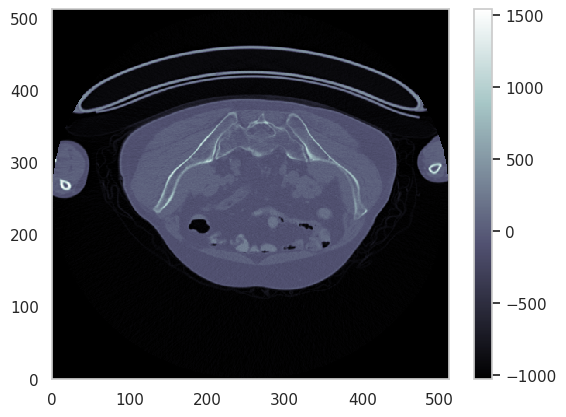

In [7]:
plt.pcolormesh(image, cmap='bone')
plt.colorbar()
plt.show()

to visualise the 3D image, we would need to loop over the files and stack them up. Not practical.

## Visualize CT Scan: MONAI

MONAI stands for Medical Open Network for AI. It is a framework for medical image analysis. MONAI has a function to load the dicom files and other functions to preprocess the data.


In [8]:
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_folder)

The CT variable is a dictionary with the image and the metadata. It contains both the pixel values (for all slices) and the metadata.

In [9]:
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

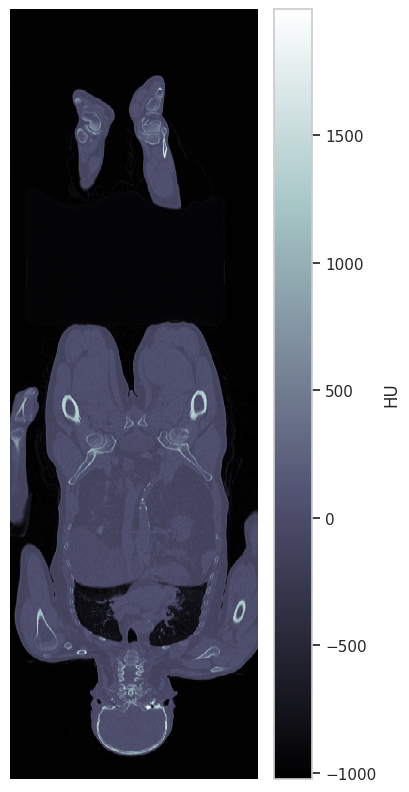

In [10]:
CT_coronal_slice = CT[:, 256].cpu().numpy()

plt.figure(figsize=(4, 10))
plt.pcolormesh(CT_coronal_slice.T, cmap='bone')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()


Notice that the person is upside down. We can manually reverse the axis, or we can use MONAI functionality to modify the CT scan. First, we add a channel dimension, since this is required for most AI applications. Then we need to reorient the CT image. The axcodes argument is a string that specifies the orientation of the image. LPS stands for left, posterior, superior.

In [11]:
print(CT.shape)

torch.Size([512, 512, 975])


In [12]:
preprocessing_pipeline = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes='LPS'),
])


In [13]:
CT = preprocessing_pipeline(CT_folder)
CT_coronal_slice = CT[0, :, 256].cpu().numpy()
print(CT.shape)

torch.Size([1, 512, 512, 975])


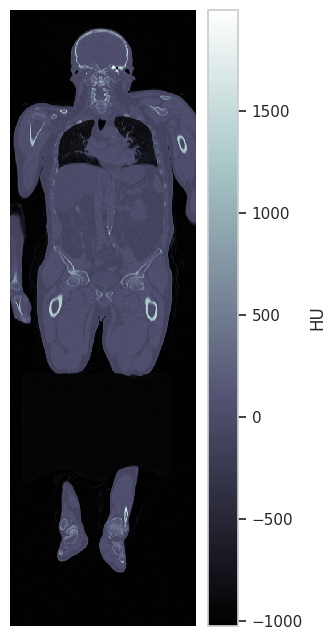

In [14]:
plt.figure(figsize=(3, 8))
plt.pcolormesh(CT_coronal_slice.T, cmap='bone')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

## Image Segmentation

First, we'll download the segmentation model from MONAI Zoo.

- Obtained from: https://monai.io/model-zoo.html

In [15]:
monal_name = "wholeBody_ct_segmentation"
#download(name = monal_name, bundle_dir=DATA_DIR)

We first set the paths where we downloaded the model parameters (model.pt) and a file called inference.json

In [16]:
model_path = os.path.join(DATA_DIR, monal_name, "models", "model.pt")
config_path = os.path.join(DATA_DIR, monal_name, "configs", "inference.json")

from this we create a config instance which lets us read from the json file.

In [17]:
config = ConfigParser()
config.read_config(config_path)

In [18]:
preprocessing = config.get_parsed_content('preprocessing')


In [19]:
data = preprocessing({'image': CT_folder})

In [20]:
data['image'].shape

torch.Size([1, 167, 167, 650])

### Model

In [21]:
model = config.get_parsed_content('network')

In [22]:
model.load_state_dict(torch.load(model_path))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

### Inference

The inferer pipeline receives as input the data and the model, and returns the model output. It contains some extra processing (in this case, it breaks the data into 96x96x96 chunks before feeding it into the model).

In [23]:
inferer = config.get_parsed_content('inferer')


### Postprocessing

Finally, once the model has finished running, there will be postprocessing that needs to be done on the data.

In [24]:
postprocessing = config.get_parsed_content('postprocessing')

### Data Loader

In [25]:
datalist = [CT_folder]
config["datalist"] = datalist
dataloader = config.get_parsed_content('dataloader')

### Prediction

We can now combine all these pipelines to obtain organ masks for our data.


In [26]:
import monai
import torch

print("MONAI version:", monai.__version__)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CUDNN version:", torch.backends.cudnn.version())


MONAI version: 1.5.dev2505
PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
CUDNN version: 90501


In [31]:
data = preprocessing({'image': CT_folder}) # returns a dictionary
print(data['image'].shape)
# 2. Compute mask predictions and add it to the dictionary


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data["image"] = data["image"].to(device)


with torch.no_grad():
    # Have to add an additional batch dimension to feed the model
    data['pred'] = inferer(data['image'].unsqueeze(0), network = model)

# remove the batch dimension in the imaage and prediction
#data['image'] = data['image'][0]
#data['pred'] = data['pred'][0]

# apply postprocessing to data
data = postprocessing(data)
#segmentation = torch.flip(data['pred'], dims=[2])
#segmentation = segmentation.cpu().numpy()


torch.Size([1, 167, 167, 650])


/tmp/ipykernel_8426/4242147602.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


NotImplementedError: Could not run 'aten::slow_conv3d_forward' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::slow_conv3d_forward' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:30477 [kernel]
Meta: registered at /pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:503 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHIP: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMPS: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradIPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradVE: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradLazy: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMTIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMeta: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_4.cpp:13493 [kernel]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:465 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:499 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]


In [40]:
dummy_input = torch.randn(1, 1, 16, 16, 16).to(device)  # Adjust input shape
output = model(dummy_input)
print(output.shape)


torch.Size([1, 105, 16, 16, 16])


In [29]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())


2.6.0+cu126
12.6
90501
True


In [30]:
import monai
import torch

print("MONAI version:", monai.__version__)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CUDNN version:", torch.backends.cudnn.version())


MONAI version: 1.4.0
PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA version: 12.6
CUDNN version: 90501


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
data["image"] = data["image"].to(device)


Using device: cuda
